In [1]:
%load_ext autoreload
%autoreload 2

train_path = "../Datasets/JSRT/Train"
test_path = "../Datasets/JSRT/Test"
val_path = "../Datasets/JSRT/Val" 

In [2]:
import sys 
sys.path.append('..')

In [3]:
from models.hybrid import Hybrid as Hybrid
from models.hybridSkip import Hybrid as Skip
from models.hybridDoubleSkip import Hybrid as DoubleSkip

import os 

import torch
from torchvision import transforms
import numpy as np

from utils.dataLoader import LandmarksDataset, ToTensor, Rescale
from sklearn.metrics import mean_squared_error
import scipy.sparse as sp
from utils.utils import scipy_to_torch_sparse, genMatrixesLH

In [4]:
img_path = os.path.join(train_path, 'Images')
label_path = os.path.join(train_path, 'landmarks')
test_dataset = LandmarksDataset(img_path=img_path,
                                 label_path=label_path,
                                 transform = transforms.Compose([
                                             Rescale(1024),
                                             ToTensor()])
                                 )

device = 'cpu'

In [58]:
def reverseVector(vector):
    RLUNG = 44
    LLUNG = 50
    HEART = 26
    RCLAV = 23
    #LCLAV = 23
    
    p1 = RLUNG*2
    p2 = p1 + LLUNG*2
    p3 = p2 + HEART*2
    p4 = p3 + RCLAV*2
    
    rl = vector[:p1].reshape(-1,2)
    ll = vector[p1:p2].reshape(-1,2)
    h = vector[p2:p3].reshape(-1,2)
    rc = vector[p3:p4].reshape(-1,2)
    lc = vector[p4:].reshape(-1,2)
    
    return rl, ll, h, rc, lc

def draw_organ(ax, array, color = 'b', bigger = None):
    N = array.shape[0]
    
    for i in range(0, N):
        x, y = array[i,:]
        
        if bigger is not None:
            if i in bigger:
                circ = plt.Circle((x, y), radius=9, color=color, fill = True)
                ax.add_patch(circ)
                circ = plt.Circle((x, y), radius=3, color='white', fill = True)
            else:
                circ = plt.Circle((x, y), radius=3, color=color, fill = True)
        else:
            circ = plt.Circle((x, y), radius=3, color=color, fill = True)
            
        ax.add_patch(circ)
    return

def draw_lines(ax, array, color = 'b'):
    N = array.shape[0]
    
    for i in range(0, N):
        x1, y1 = array[i-1,:]
        x2, y2 = array[i,:]
        
        ax.plot([x1, x2], [y1, y2], color=color, linestyle='-', linewidth=1)
    return

def drawOrgans(ax, vector, title = '', img =  None):
    
    vector = vector.reshape(-1, 1)
    right_lung, left_lung, heart, right_clavicle, left_clavicle = reverseVector(vector)
    
    if img is not None:
        plt.imshow(img, cmap='gray')
    
    #ax.set_ylim(1024, 0)
    #ax.set_xlim(0, 1024)
    #fig.gca().set_aspect('equal', adjustable='box')
    
    draw_lines(ax, right_lung, 'r')
    draw_lines(ax, left_lung, 'g')
    draw_lines(ax, heart, 'y')
    draw_lines(ax, right_clavicle, 'b')
    draw_lines(ax, left_clavicle, 'darkorange')
    
    #draw_organ(ax, right_lung, 'r', RL)
    #draw_organ(ax, left_lung, 'g', LL)
    #draw_organ(ax, heart, 'y', H)
    #draw_organ(ax, right_clavicle, 'b')
    #draw_organ(ax, left_clavicle, 'darkorange')

    ax.set_title(title)
    
    return

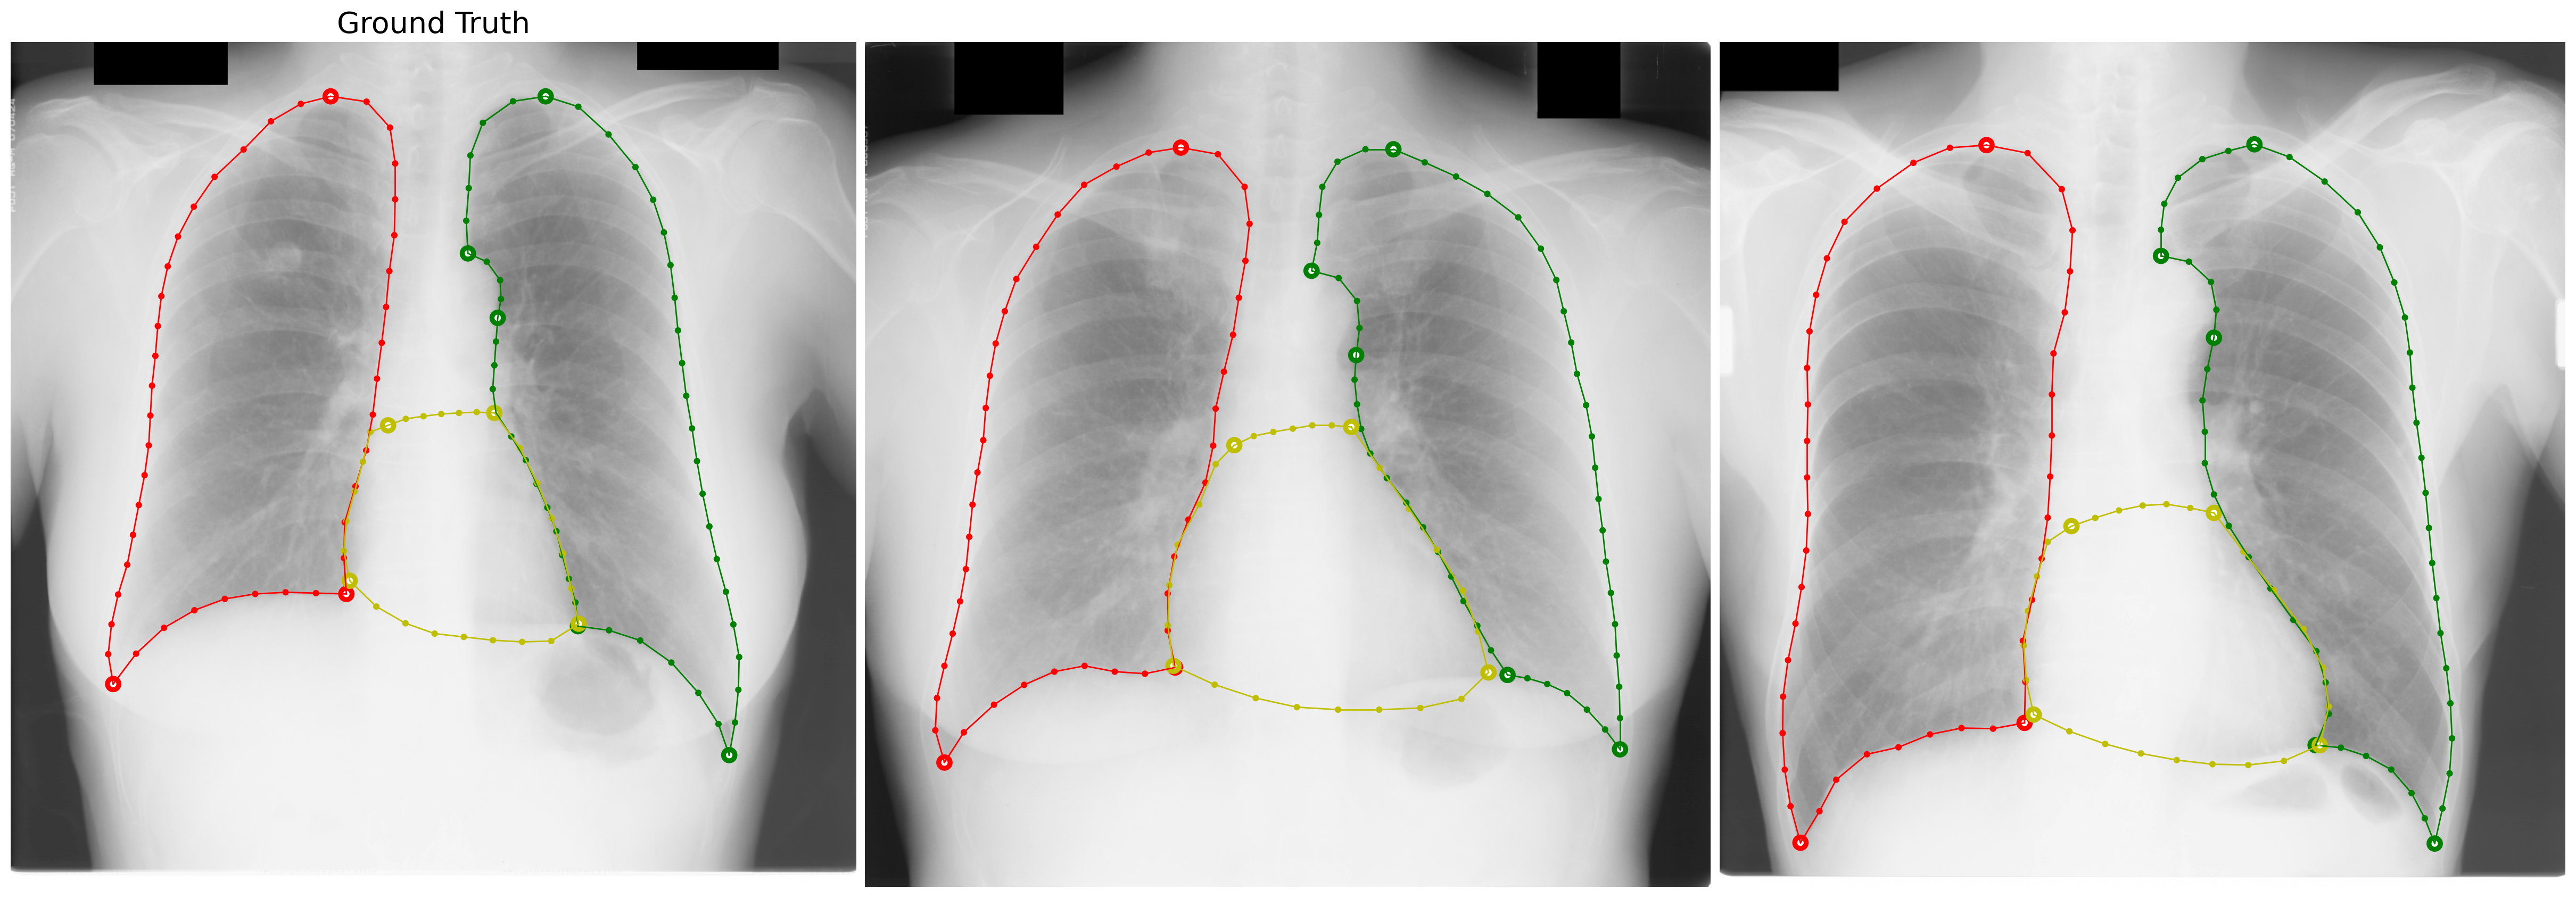

In [5]:
from utils.fun import drawOrgans
import matplotlib.pyplot as plt

#model_list_ = [pcaNet, vae, hybrid, Skip6, double65]
#model_names_ = ['PCA', 'FC', 'HybridGNet', '1-IGSC Layer 6', '2-IGSC Layers 6-5']

i_ =[4, 13, 44]

fig = plt.figure(figsize=(24, 8), dpi= 200)

c = 0

for i in i_:
    with torch.no_grad():
        sample = test_dataset[i]

        data, target = sample['image'], sample['landmarks']
        data = torch.unsqueeze(data, 0).to(device)
        target = target.reshape(-1).numpy()

        draw = data.cpu().numpy()[0,0,:,:]
        
        ax = plt.subplot(1, 3, c+1)
        # 3, 8, 1+ c*8
        plt.axis('off')
        plt.xlim(1, 1024)
        plt.ylim(1024, 1)
        
        target = np.clip(target, 0, 1)
        if c == 0:
            drawOrgans(ax, target[:240] * 1024, None, draw.copy())
            plt.title("Ground Truth", fontsize = 20)
        else:
            drawOrgans(ax, target[:240] * 1024, None, draw.copy())
        
        c += 1
        
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.01, hspace=0)      
plt.savefig('figs/compare_UNet.png', bbox_inches = 'tight', dpi=200)
plt.savefig('figs/compare_UNet.pdf', bbox_inches = 'tight', dpi=200)

In [6]:
sample = test_dataset[0]
data, target = sample['image'], sample['landmarks']

In [54]:
print(sample['image'].size())
print(data.size())

torch.Size([1, 1024, 1024])
torch.Size([1, 1, 1024, 1024])


In [55]:
print(sample['landmarks'].size())
print(test_dataset[100]['landmarks'].size())

torch.Size([166, 2])
torch.Size([166, 2])


In [38]:
import pathlib
import re
from skimage import io

def natural_key(string_):
    """See http://www.codinghorror.com/blog/archives/001018.html"""
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]

data_root = pathlib.Path(img_path)
all_files = list(data_root.glob('*.png'))
all_files = [str(path) for path in all_files]
all_files.sort(key = natural_key)

images = all_files

idx=0

if torch.is_tensor(idx):
    idx = idx.tolist()

img_name = images[idx]
image1 = io.imread(img_name).astype('float') / 255.0
image2 = np.expand_dims(image1, axis=2)

label = img_name.replace(img_path, label_path).replace('.png', '.npy')
landmarks1 = np.load(label)
landmarks2 = landmarks1.astype('float').reshape(-1, 2)

sample_ = {'image': image2, 'landmarks': landmarks2}


In [40]:
#print(landmarks2)

transform = transforms.Compose([
                                             Rescale(1024),
                                             ToTensor()])

sample2=transform(sample_)
print(sample2['landmarks'])

tensor([[0.3770, 0.0801],
        [0.3397, 0.0889],
        [0.3025, 0.1055],
        [0.2652, 0.1323],
        [0.2358, 0.1675],
        [0.2132, 0.2048],
        [0.1982, 0.2420],
        [0.1885, 0.2793],
        [0.1816, 0.3165],
        [0.1797, 0.3538],
        [0.1758, 0.3910],
        [0.1709, 0.4283],
        [0.1709, 0.4655],
        [0.1680, 0.5028],
        [0.1641, 0.5400],
        [0.1621, 0.5773],
        [0.1602, 0.6145],
        [0.1572, 0.6518],
        [0.1518, 0.6890],
        [0.1475, 0.7263],
        [0.1465, 0.7635],
        [0.1514, 0.8008],
        [0.1774, 0.7679],
        [0.2102, 0.7361],
        [0.2430, 0.7101],
        [0.2759, 0.6968],
        [0.3087, 0.6914],
        [0.3416, 0.6941],
        [0.3744, 0.7051],
        [0.4072, 0.7178],
        [0.4131, 0.6721],
        [0.4131, 0.6264],
        [0.4229, 0.5807],
        [0.4375, 0.5350],
        [0.4521, 0.4893],
        [0.4590, 0.4436],
        [0.4551, 0.3979],
        [0.4600, 0.3521],
        [0.4

In [23]:
from medpy.metric import dc, hd, assd, jc, asd
from utils.fun import reverseVector, drawBinary

def evalImageMetrics(blank, output, target_lungs, target_heart):
    p1, p2, h, c1, c2 = reverseVector(output)
    
    ptest = drawBinary(blank.copy(), p1)
    ptest = drawBinary(ptest, p2)
    
    hdp = hd(ptest, target_lungs, voxelspacing = 0.35)
    dcp = dc(ptest, target_lungs)

    p1, p2, h, c1, c2 = reverseVector(output)
    
    ptest = drawBinary(blank.copy(), h)
    
    hdc = hd(ptest, target_heart, voxelspacing = 0.35)
    dcc = dc(ptest, target_heart)
    
    return [dcp, dcc, hdp, hdc]

def evalImageMetricsUNet(output, target_lungs, target_heart):
    dcp = dc(output == 1, target_lungs)
    dcc = dc(output == 2, target_heart)
    
    hdp = hd(output == 1, target_lungs, voxelspacing = 0.35)
    hdc = hd(output == 2, target_heart, voxelspacing = 0.35)
        
    return [dcp, dcc, hdp, hdc]

In [24]:
blank = np.zeros([1024, 1024])

results = pd.DataFrame()

for i in range(0, len(test_dataset.images)):
    print('\r',i+1,'of', len(test_dataset.images),end='')
    with torch.no_grad():
        sample = test_dataset[i]

        data, target = sample['image'], sample['landmarks']
        data = torch.unsqueeze(data, 0).to(device)
        target =  target.reshape(-1).numpy()
        
        p1, p2, h, c1, c2 = reverseVector(target * 1024)
       
        t_lungs = drawBinary(blank.copy(), p1)
        t_lungs = drawBinary(t_lungs, p2)
        t_heart = drawBinary(blank.copy(), h)
        
        for j in range(0, len(model_list)):
            output = model_list[j](data)
            if len(output) > 1:
                output = output[0]
                
            output = output.cpu().numpy().reshape(-1) 
            
            metrics = evalImageMetrics(blank, output * 1024, t_lungs, t_heart)
             
            aux = pd.DataFrame([[i, model_names[j]] + metrics], columns=['i','Model','Dice Lungs','Dice Heart','HD Lungs','HD Heart'])
            results = results.append(aux, ignore_index = True)
        
        out = modelUNet(data)[0,:,:,:]
        seg = torch.argmax(out, axis = 0).cpu().numpy()
        metrics = evalImageMetricsUNet(seg, t_lungs, t_heart)
        
        aux = pd.DataFrame([[i, 'UNet'] + metrics], columns=['i','Model','Dice Lungs','Dice Heart','HD Lungs','HD Heart'])
        results = results.append(aux, ignore_index = True)

 51 of 51

In [25]:
for i in range(0, len(all_files)):
    print('\r',i+1,'of', len(all_files),end='')
    
    data = np.load(all_files[i])[:240]
    target = np.load(all_files[i].replace(folder, test))[:240]
    
    p1, p2, h, c1, c2 = reverseVector(target)
       
    t_lungs = drawBinary(blank.copy(), p1)
    t_lungs = drawBinary(t_lungs, p2)
    t_heart = drawBinary(blank.copy(), h)
        
    metrics = evalImageMetrics(blank, data, t_lungs, t_heart)
        
    aux = pd.DataFrame([[i, "MultiAtlas"] + metrics], columns=['i','Model','Dice Lungs','Dice Heart','HD Lungs','HD Heart'])#, 'ASD Lungs', 'ASD Heart'])
    results = results.append(aux, ignore_index = True)

 51 of 51

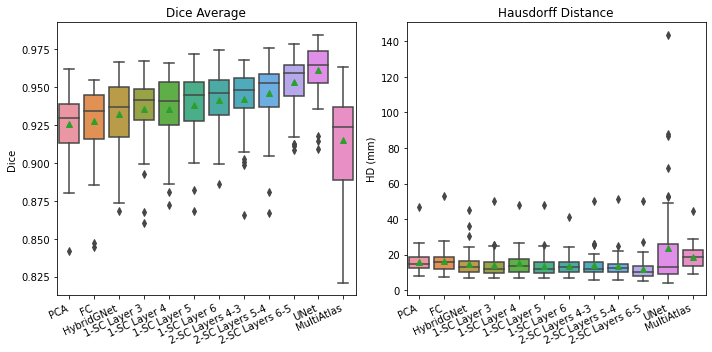

Dice
PCA 0.926 +- 0.022
FC 0.928 +- 0.024
HybridGNet 0.933 +- 0.022
1-SC Layer 3 0.935 +- 0.023
1-SC Layer 4 0.936 +- 0.023
1-SC Layer 5 0.939 +- 0.022
1-SC Layer 6 0.942 +- 0.018
2-SC Layers 4-3 0.942 +- 0.021
2-SC Layers 5-4 0.946 +- 0.023
2-SC Layers 6-5 0.953 +- 0.018
MultiAtlas 0.915 +- 0.032
UNet 0.961 +- 0.017

Hausdorff
PCA 16.017 +- 6.130
FC 16.278 +- 6.866
HybridGNet 14.670 +- 6.984
1-SC Layer 3 13.988 +- 6.951
1-SC Layer 4 15.100 +- 7.031
1-SC Layer 5 13.700 +- 6.507
1-SC Layer 6 13.343 +- 5.471
2-SC Layers 4-3 14.075 +- 6.906
2-SC Layers 5-4 13.555 +- 6.739
2-SC Layers 6-5 11.862 +- 6.880
MultiAtlas 18.549 +- 6.515
UNet 23.503 +- 26.140



In [26]:
import matplotlib.ticker as mticker

results['Dice Average'] = results[['Dice Lungs', 'Dice Heart']].mean(axis=1)
results['HD Average'] = results[['HD Lungs', 'HD Heart']].mean(axis=1)

plt.figure(figsize = (10,5))
plt.tight_layout()
ax = plt.subplot(1,2,1)
sns.boxplot(x = 'Model', y = 'Dice Average', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('Dice')
plt.title('Dice Average')
plt.xlabel(None)

ax = plt.subplot(1,2,2)
sns.boxplot(x = 'Model', y = 'HD Average', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('HD (mm)')
plt.title('Hausdorff Distance')
plt.xlabel(None)

plt.tight_layout()
#plt.savefig('figs/num3.png', dpi=300)
plt.show()

print('Dice')
for model in model_names:
    print(model, '%.3f'%np.mean(results['Dice Average'][results['Model'] == model]), '+- %.3f' % np.std(results['Dice Average'][results['Model'] == model]))

print('')

print('Hausdorff')
for model in model_names:
    print(model, '%.3f'%np.mean(results['HD Average'][results['Model'] == model]), '+- %.3f' % np.std(results['HD Average'][results['Model'] == model]))

print('')

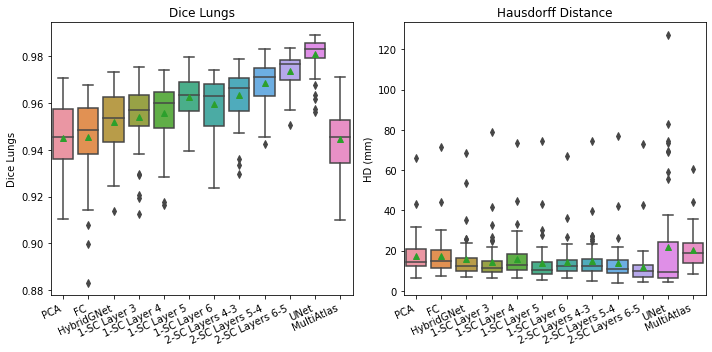

Dice
PCA 0.945 +- 0.014
FC 0.945 +- 0.017
HybridGNet 0.952 +- 0.013
1-SC Layer 3 0.954 +- 0.013
1-SC Layer 4 0.956 +- 0.013
1-SC Layer 5 0.963 +- 0.009
1-SC Layer 6 0.960 +- 0.011
2-SC Layers 4-3 0.963 +- 0.011
2-SC Layers 5-4 0.968 +- 0.009
2-SC Layers 6-5 0.974 +- 0.007
MultiAtlas 0.944 +- 0.013
UNet 0.981 +- 0.008

Hausdorff
PCA 17.441 +- 9.669
FC 17.531 +- 10.352
HybridGNet 15.654 +- 10.782
1-SC Layer 3 14.582 +- 11.328
1-SC Layer 4 16.044 +- 11.175
1-SC Layer 5 13.639 +- 10.978
1-SC Layer 6 14.324 +- 9.122
2-SC Layers 4-3 14.942 +- 10.589
2-SC Layers 5-4 13.722 +- 10.871
2-SC Layers 6-5 12.094 +- 10.476
MultiAtlas 20.317 +- 9.344
UNet 21.839 +- 26.032



In [27]:
plt.figure(figsize = (10,5))
plt.tight_layout()
ax = plt.subplot(1,2,1)
sns.boxplot(x = 'Model', y = 'Dice Lungs', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('Dice Lungs')
plt.title('Dice Lungs')
plt.xlabel(None)

ax = plt.subplot(1,2,2)
sns.boxplot(x = 'Model', y = 'HD Lungs', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('HD (mm)')
plt.title('Hausdorff Distance')
plt.xlabel(None)

plt.tight_layout()
#plt.savefig('figs/num2.png', dpi=300)
plt.show()

print('Dice')
for model in model_names:
    print(model, '%.3f'%np.mean(results['Dice Lungs'][results['Model'] == model]), '+- %.3f' % np.std(results['Dice Lungs'][results['Model'] == model]))

print('')

print('Hausdorff')
for model in model_names:
    print(model, '%.3f'%np.mean(results['HD Lungs'][results['Model'] == model]), '+- %.3f' % np.std(results['HD Lungs'][results['Model'] == model]))

print('')

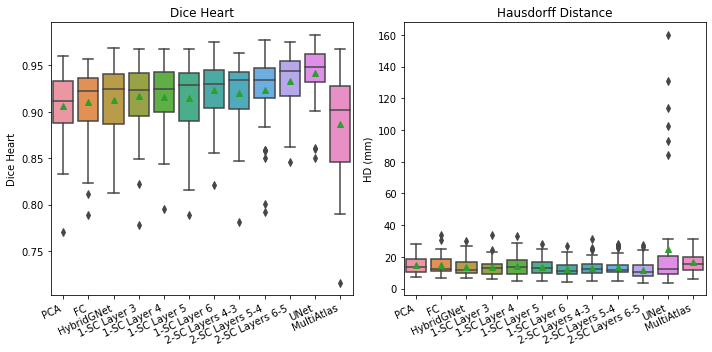

Dice
PCA 0.906 +- 0.037
FC 0.910 +- 0.039
HybridGNet 0.913 +- 0.037
1-SC Layer 3 0.917 +- 0.037
1-SC Layer 4 0.916 +- 0.038
1-SC Layer 5 0.915 +- 0.039
1-SC Layer 6 0.924 +- 0.030
2-SC Layers 4-3 0.921 +- 0.035
2-SC Layers 5-4 0.924 +- 0.040
2-SC Layers 6-5 0.933 +- 0.031
MultiAtlas 0.886 +- 0.056
UNet 0.942 +- 0.030

Hausdorff
PCA 14.592 +- 5.391
FC 15.025 +- 5.791
HybridGNet 13.685 +- 5.515
1-SC Layer 3 13.394 +- 5.331
1-SC Layer 4 14.157 +- 6.012
1-SC Layer 5 13.761 +- 5.102
1-SC Layer 6 12.361 +- 4.799
2-SC Layers 4-3 13.208 +- 5.537
2-SC Layers 5-4 13.388 +- 6.053
2-SC Layers 6-5 11.631 +- 5.602
MultiAtlas 16.780 +- 6.839
UNet 25.168 +- 34.233



In [28]:
plt.figure(figsize = (10,5))
plt.tight_layout()
ax = plt.subplot(1,2,1)
sns.boxplot(x = 'Model', y = 'Dice Heart', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('Dice Heart')
plt.title('Dice Heart')
plt.xlabel(None)

ax = plt.subplot(1,2,2)
sns.boxplot(x = 'Model', y = 'HD Heart', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('HD (mm)')
plt.title('Hausdorff Distance')
plt.xlabel(None)

plt.tight_layout()
#plt.savefig('figs/num1.png', dpi=300)
plt.show()

print('Dice')
for model in model_names:
    print(model, '%.3f'%np.mean(results['Dice Heart'][results['Model'] == model]), '+- %.3f' % np.std(results['Dice Heart'][results['Model'] == model]))

print('')

print('Hausdorff')
for model in model_names:
    print(model, '%.3f'%np.mean(results['HD Heart'][results['Model'] == model]), '+- %.3f' % np.std(results['HD Heart'][results['Model'] == model]))

print('')

# Supplementary Results

In [29]:
from scipy.stats import wilcoxon

model_names = ['PCA', 'VAE', 'MultiAtlas', 'HybridGNet', '1-SC Layer 3', '1-SC Layer 4','1-SC Layer 5','1-SC Layer 6', '2-SC Layers 4-3', '2-SC Layers 5-4', '2-SC Layers 6-5']

nmodels = len(model_names)

pvalues_mse = np.zeros([nmodels,nmodels])

for i in range(0, nmodels):
    for j in range(i+1, nmodels):
        model1 = model_names[i]
        model2 = model_names[j]
                
        mse1 = results1[results1['Model'] == model1]['MSE']
        mse2 = results1[results1['Model'] == model2]['MSE']
        
        pvalue = wilcoxon(mse1, mse2)
        
        pvalues_mse[i, j] = pvalue[1]
        

pvalues_df = pd.DataFrame(pvalues_mse, columns = model_names)
pvalues_df.index = model_names

fig, ax = plt.subplots(figsize=(12, 9), dpi = 100)

# mask
mask = np.tril(np.ones_like(pvalues_df, dtype=bool))

mask = mask[:-1, 1:]
pvalues = pvalues_df.iloc[:-1,1:].copy()

# plot heatmap
sns.heatmap(pvalues, mask=mask, annot=True, fmt=".2e", cmap='Blues_r',
            vmin=0, vmax=0.1, cbar = False)
# yticks
plt.yticks(rotation=0)
plt.title('MSE comparison over Wilcoxon test (p-values)', x = 0.4)

plt.savefig('figs/JSRT_MSE_wilcoxon.png', bbox_inches = 'tight')
plt.show()

ValueError: The samples x and y must have the same length.

In [ ]:
model_names.append('UNet')

nmodels = len(model_names)

pvalues_mse = np.zeros([nmodels,nmodels])

for i in range(0, nmodels):
    for j in range(i+1, nmodels):
        model1 = model_names[i]
        model2 = model_names[j]
                
        mse1 = results[results['Model'] == model1]['Dice Lungs']
        mse2 = results[results['Model'] == model2]['Dice Lungs']
        pvalue = wilcoxon(mse1, mse2)
        
        pvalues_mse[i, j] = pvalue[1]        

pvalues_df = pd.DataFrame(pvalues_mse, columns = model_names)
pvalues_df.index = model_names

fig, ax = plt.subplots(figsize=(12, 9), dpi = 100)

# mask
mask = np.tril(np.ones_like(pvalues_df, dtype=bool))

mask = mask[:-1, 1:]
pvalues = pvalues_df.iloc[:-1,1:].copy()

# plot heatmap
sns.heatmap(pvalues, mask=mask, annot=True, fmt=".2e", cmap='Blues_r',
            vmin=0, vmax=0.1, cbar = False)
# yticks
plt.yticks(rotation=0)
plt.title('Dice lungs comparison over Wilcoxon test (p-values)', x = 0.4)

plt.savefig('figs/JSRT_dice_wilcoxon_lungs.png', bbox_inches='tight')
plt.show()

In [ ]:
nmodels = len(model_names)

pvalues_mse = np.zeros([nmodels,nmodels])

for i in range(0, nmodels):
    for j in range(i+1, nmodels):
        model1 = model_names[i]
        model2 = model_names[j]
                
        mse1 = results[results['Model'] == model1]['Dice Heart']
        mse2 = results[results['Model'] == model2]['Dice Heart']
        pvalue = wilcoxon(mse1, mse2)
        
        pvalues_mse[i, j] = pvalue[1]        

pvalues_df = pd.DataFrame(pvalues_mse, columns = model_names)
pvalues_df.index = model_names

fig, ax = plt.subplots(figsize=(12, 9), dpi = 100)

# mask
mask = np.tril(np.ones_like(pvalues_df, dtype=bool))

mask = mask[:-1, 1:]
pvalues = pvalues_df.iloc[:-1,1:].copy()

# plot heatmap
sns.heatmap(pvalues, mask=mask, annot=True, fmt=".2e", cmap='Blues_r',
            vmin=0, vmax=0.1, cbar = False)
# yticks
plt.yticks(rotation=0)
plt.title('Dice heart comparison over Wilcoxon test (p-values)', x = 0.4)

plt.savefig('figs/JSRT_dice_wilcoxon_heart.png', bbox_inches='tight')
plt.show()

In [ ]:
nmodels = len(model_names)

pvalues_mse = np.zeros([nmodels,nmodels])

for i in range(0, nmodels):
    for j in range(i+1, nmodels):
        model1 = model_names[i]
        model2 = model_names[j]
                
        mse1 = results[results['Model'] == model1]['HD Lungs']
        mse2 = results[results['Model'] == model2]['HD Lungs']
        pvalue = wilcoxon(mse1, mse2)
        
        pvalues_mse[i, j] = pvalue[1]        

pvalues_df = pd.DataFrame(pvalues_mse, columns = model_names)
pvalues_df.index = model_names

fig, ax = plt.subplots(figsize=(12, 9), dpi = 100)

# mask
mask = np.tril(np.ones_like(pvalues_df, dtype=bool))

mask = mask[:-1, 1:]
pvalues = pvalues_df.iloc[:-1,1:].copy()

# plot heatmap
sns.heatmap(pvalues, mask=mask, annot=True, fmt=".2e", cmap='Blues_r',
            vmin=0, vmax=0.1, cbar = False)
# yticks
plt.yticks(rotation=0)
plt.title('HD lungs comparison over Wilcoxon test (p-values)', x = 0.4)

plt.savefig('figs/JSRT_HD_wilcoxon_lungs.png', bbox_inches='tight')
plt.show()

In [ ]:
nmodels = len(model_names)

pvalues_mse = np.zeros([nmodels,nmodels])

for i in range(0, nmodels):
    for j in range(i+1, nmodels):
        model1 = model_names[i]
        model2 = model_names[j]
                
        mse1 = results[results['Model'] == model1]['HD Heart']
        mse2 = results[results['Model'] == model2]['HD Heart']
        pvalue = wilcoxon(mse1, mse2)
        
        pvalues_mse[i, j] = pvalue[1]        

pvalues_df = pd.DataFrame(pvalues_mse, columns = model_names)
pvalues_df.index = model_names

fig, ax = plt.subplots(figsize=(12, 9), dpi = 100)

# mask
mask = np.tril(np.ones_like(pvalues_df, dtype=bool))

mask = mask[:-1, 1:]
pvalues = pvalues_df.iloc[:-1,1:].copy()

# plot heatmap
sns.heatmap(pvalues, mask=mask, annot=True, fmt=".2e", cmap='Blues_r',
            vmin=0, vmax=0.1, cbar = False)
# yticks
plt.yticks(rotation=0)
plt.title('HD heart comparison over Wilcoxon test (p-values)', x = 0.4)

plt.savefig('figs/JSRT_HD_wilcoxon_heart.png', bbox_inches='tight')
plt.show()

In [13]:
import cv2
import numpy as np 
import os

trainlist = open('/home/hpcpin1/Seg_Project/Datasets/JSRT/train_files.txt','r').read().splitlines()
f=trainlist[0]

p = os.path.join('/home/hpcpin1/Seg_Project/Datasets/JSRT/All247images', f)
        
w, h = 2048, 2048 

with open(p, 'rb') as path: 
    dtype = np.dtype('>u2')
    img0 = np.fromfile(path, dtype=dtype)
    img1 = img0.reshape((h,w)) 

img2 = 1 - img1.astype('float')  / 4096
img3 = cv2.resize(img2, (1024,1024))
img4 = img3*255
       

imageJSRT = cv2.imread('./cepha400/cepha400/' + img_landmarks[0], 0)
imageCepha = cv2.imread('./cepha400/cepha400/' + img_landmarks[0], 0)

In [15]:
np.zeros([0,0])

array([], shape=(0, 0), dtype=float64)